In [2]:
import pandas as pd
import numpy as np
from scipy.signal import butter, filtfilt, find_peaks
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

In [3]:
data = pd.read_csv(r"D:\My projects\Health Tracker Band\IMUWorkoutClassification\AppleWatchRecordings\Whales1\241124_IDBC_W7_5_S1_R14-2024-11-24_08-04-33.csv")

In [29]:
filtered_data = data[
    (data['seconds_elapsed'] >= 4) &
    (data['seconds_elapsed'] <= (data['seconds_elapsed'].max() - 20)) &
    (data['seconds_elapsed'] <= 90)
]

In [30]:
# Step 3: Combine rotation and gravity signals
rotation_and_gravity_signals = filtered_data[
    [
        'wristMotion_rotationRateX', 'wristMotion_rotationRateY', 'wristMotion_rotationRateZ',
        'wristMotion_gravityX', 'wristMotion_gravityY', 'wristMotion_gravityZ'
    ]
]

# Calculate the combined signal (Euclidean norm of rotation and gravity components)
combined_signal = np.sqrt((rotation_and_gravity_signals**2).sum(axis=1))

In [31]:
# Step 4: Apply a low-pass filter to remove frequencies above 0.25 Hz
def low_pass_filter(signal, cutoff, sampling_rate, order=4):
    nyquist = 0.5 * sampling_rate
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, signal)

# Estimate sampling rate from time differences
sampling_rate = 1.1 / np.mean(np.diff(filtered_data['seconds_elapsed']))
filtered_signal = low_pass_filter(combined_signal, cutoff=0.23, sampling_rate=sampling_rate)

In [32]:
# Step 5: Detect peaks with amplitude range (1.75 to 4) and a minimum spacing of 1 second
peaks, _ = find_peaks(
    filtered_signal,
    height=(1.55, 4),  # Amplitude range for valid peaks
    distance=int(sampling_rate)  # Minimum spacing = 1 second
)

# Extract the times of detected peaks
detected_peak_times = filtered_data['seconds_elapsed'].iloc[peaks]

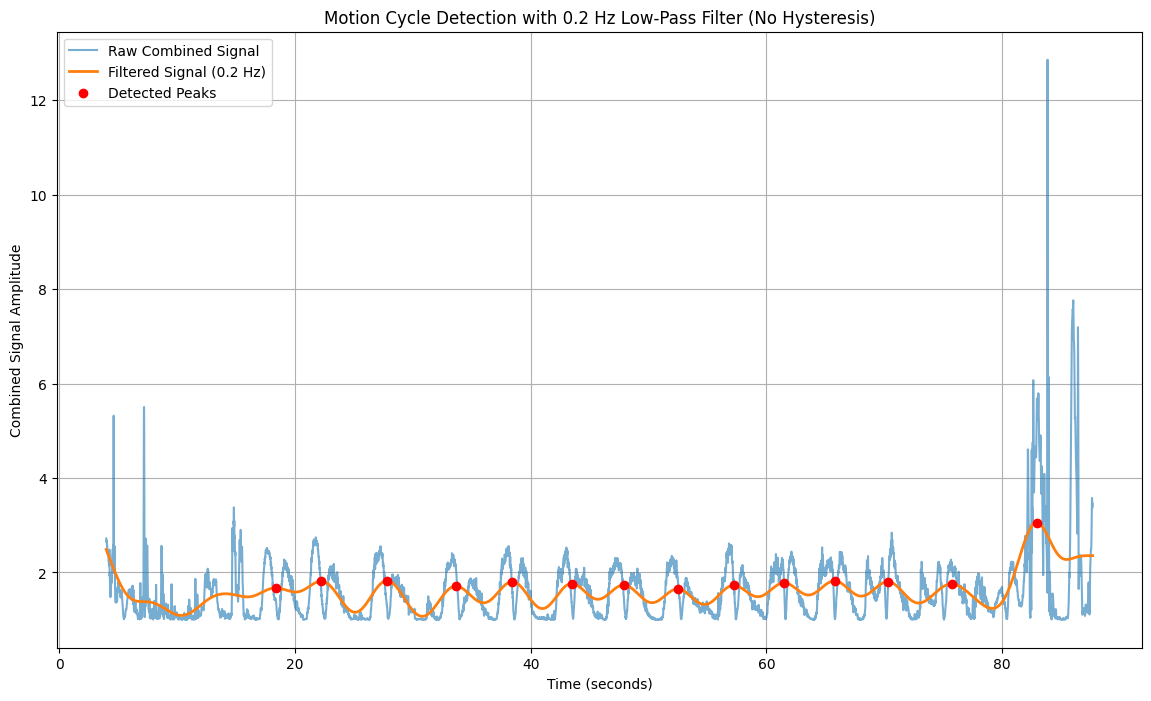

In [33]:

# Step 6: Visualize the raw combined signal, filtered signal, and detected peaks
plt.figure(figsize=(14, 8))
plt.plot(filtered_data['seconds_elapsed'], combined_signal, label='Raw Combined Signal', linewidth=1.5, alpha=0.6)
plt.plot(filtered_data['seconds_elapsed'], filtered_signal, label='Filtered Signal (0.2 Hz)', linewidth=2)
plt.scatter(detected_peak_times, filtered_signal[peaks], color='red', label='Detected Peaks', zorder=5)
plt.title('Motion Cycle Detection with 0.2 Hz Low-Pass Filter (No Hysteresis)')
plt.xlabel('Time (seconds)')
plt.ylabel('Combined Signal Amplitude')
plt.grid(True)
plt.legend()
plt.show()